In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
import partridge as ptg
import pyproj
from tqdm import tqdm
import osmnx as ox
import h3

def load_city_data(city_shapefile, resolution=8):
    city = gpd.read_file(city_shapefile)
    city = city.to_crs(epsg=4326)
    
    # Handle potential MultiPolygons
    if isinstance(city.geometry.iloc[0], MultiPolygon):
        polygons = [poly for multipoly in city.geometry for poly in multipoly.geoms]
    else:
        polygons = city.geometry

    # Create a hexagonal grid
    hex_ids = set()
    for polygon in polygons:
        hex_ids.update(h3.polyfill(polygon.__geo_interface__, resolution))
    
    hex_ids = list(hex_ids)
    hexagons = []
    for hex_id in hex_ids:
        hex_boundary = h3.h3_to_geo_boundary(hex_id)
        hexagons.append(Polygon(hex_boundary))
    
    points = gpd.GeoDataFrame(geometry=[Point(h3.h3_to_geo(h)) for h in hex_ids], crs='epsg:4326')
    return city, points, gpd.GeoDataFrame(geometry=hexagons, crs='epsg:4326')


C:\Users\rmlaz\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Carichiamo Roma

In [2]:
roma, punti, roma_hex=load_city_data('municipi.geojson')

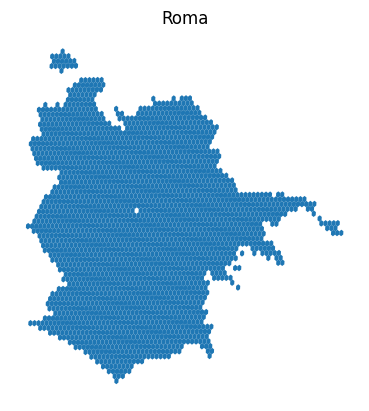

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# cute roma_hex plot

roma_hex.plot(ax=ax,)

ax.set_axis_off()

ax.set_title('Roma')

fig.savefig('roma_hex.png', dpi=300, bbox_inches='tight')
plt.show()

### Carichiamo dataset Mobilità

In [4]:
def load_gtfs_data(gtfs_path):
    feed = ptg.load_feed(gtfs_path)
    stops = feed.stops
    stop_times = feed.stop_times
    return stops, stop_times

stops, stop_times = load_gtfs_data('./rome_static_gtfs')
feed=ptg.load_feed('./rome_static_gtfs')

In [5]:
def reverse_seconds_to_hms(ssm):
    # Calculate hours
    h = int(ssm // 3600)
    
    # Calculate remaining seconds after extracting hours
    remaining_seconds = int(ssm % 3600)
    
    # Calculate minutes
    m = int(remaining_seconds // 60)
    
    # Calculate remaining seconds after extracting minutes
    s = int(remaining_seconds % 60)
    
    return f'{h:02d}:{m:02d}:{s:02d}'



stop_times['arrival_time_hms'] = stop_times.arrival_time.apply(reverse_seconds_to_hms)
stop_times['departure_time_hms'] = stop_times.departure_time.apply(reverse_seconds_to_hms)

### Troviamo punti di interesse

In [6]:
## ospedali in questo caso

def get_hospitals(city):
    """Fetch hospitals within the city using OSMnx."""
    hospitals = ox.geometries_from_polygon(city.unary_union, tags={'amenity': 'hospital'})
    hospitals = hospitals.to_crs(epsg=4326)
    return hospitals

def find_nearest_stop(point, stops):
    # fix points that are not points
    if isinstance(point, Polygon):
        point = point.centroid
    if isinstance(point, MultiPolygon):
        point = point.centroid
    # calculate distances
    distances = stops.apply(lambda row: pyproj.Geod(ellps='WGS84').inv(point.x, point.y, row['stop_lon'], row['stop_lat'])[2], axis=1)
    return stops.iloc[distances.idxmin()]

hospitals = get_hospitals(roma)

C:\Users\rmlaz\AppData\Local\Temp\ipykernel_12656\420877171.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  hospitals = ox.geometries_from_polygon(city.unary_union, tags={'amenity': 'hospital'})


In [7]:
hospitals

geometry  \
element_type osmid                                                           
node         434692525                           POINT (12.39839 41.88708)   
             804465318                           POINT (12.44864 41.80236)   
             1273194519                          POINT (12.44905 41.90800)   
             2824672193                          POINT (12.27079 41.73250)   
             4370802641                          POINT (12.44798 41.80211)   
...                                                                    ...   
relation     2858036     POLYGON ((12.46479 41.90895, 12.46474 41.90905...   
             12702996    POLYGON ((12.30024 41.72764, 12.30034 41.72763...   
             14312289    POLYGON ((12.46881 41.98373, 12.46880 41.98369...   
             17024292    POLYGON ((12.38009 41.78450, 12.37993 41.78457...   
             17024293    POLYGON ((12.38082 41.78437, 12.38126 41.78416...   

                        source   amenity emergency  \
element_type osmid                                   
node         434692525     NaN  hospital       yes   
             804465318     NaN  hospital       NaN   
             1273194519    NaN  hospital       yes   
             2824672193    BAG  hospital       NaN   
             4370802641    NaN  hospital       NaN   
...                        ...       ...       ...   
relation     2858036       NaN  hospital       NaN   
             12702996      NaN  hospital       yes   
             14312289      NaN  hospital       NaN   
             17024292      NaN  hospital       NaN   
             17024293      NaN  hospital       NaN   

                                              fixme healthcare  \
element_type osmid                                               
node         434692525   should better be a polygon   hospital   
             804465318                          NaN   hospital   
             1273194519                         NaN   hospital   
             2824672193                         NaN   hospital   
             4370802641                         NaN   hospital   
...                                             ...        ...   
relation     2858036                            NaN     clinic   
             12702996                           NaN   hospital   
             14312289                           NaN        NaN   
             17024292                           NaN   hospital   
             17024293                           NaN   hospital   

                                                                      name  \
element_type osmid                                                           
node         434692525                                    Aurelia Hospital   
             804465318   I.F.O. Istituto Regina Elena e Istituto San Ga...   
             1273194519                 Pronto Soccorso Ospedale Oftalmico   
             2824672193          Distretto di salute mentale A.S.L. Roma D   
             4370802641                 Istituti Fisioterapici Ospedalieri   
...                                                                    ...   
relation     2858036                           Casa di Cura Santa Famiglia   
             12702996                    Ospedale Giovanni Battista Grassi   
             14312289                                 Ospedale Sant'Andrea   
             17024292                       Poliambulatorio Casalbernocchi   
             17024293                         ASL Roma 3 - Casal Bernocchi   

                                                     url wheelchair  \
element_type osmid                                                    
node         434692525   http://www.aureliahospital.com/        yes   
             804465318                               NaN        NaN   
             1273194519                              NaN        NaN   
             2824672193                              NaN        NaN   
             4370802641                         

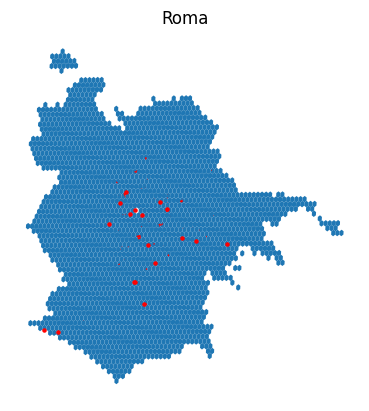

In [8]:
# plot hospitals over roma_hex

fig, ax = plt.subplots()

roma_hex.plot(ax=ax,)

hospitals.plot(ax=ax, color='red', markersize=5)

ax.set_axis_off()

ax.set_title('Roma')

fig.savefig('roma_hospitals.png', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
fermate_hospitals = hospitals.apply(lambda row: find_nearest_stop(row.geometry, stops), axis=1)

In [10]:
# flatten the df

fermate_hospitals = fermate_hospitals.reset_index(drop=True)

### Calcoli grafi

In [11]:
# function to calculate walking time between two points using osmnx

def calculate_walking_time(point1, point2, graph):
    # fix points that are not points
    if isinstance(point1, Polygon):
        point1 = point1.centroid
    if isinstance(point1, MultiPolygon):
        point1 = point1.centroid
    if isinstance(point2, Polygon):
        point2 = point2.centroid
    if isinstance(point2, MultiPolygon):
        point2 = point2.centroid
        
    travel_speed = 4.5 # km/h
        
    # calculate walking time using OSMnx and the walking network    
    # first find the nearest nodes to the points
    origin_node = ox.distance.nearest_nodes(graph,point1.x, point1.y)
    destination_node = ox.distance.nearest_nodes(graph, point2.x, point2.y)
    
    # then calculate the shortest path between the nodes
    route = ox.distance.shortest_path(graph, origin_node, destination_node, weight='length')
    
    # then calculate the length of the route
    route_length = sum(ox.utils_graph.get_route_edge_attributes(graph, route, 'length'))
    
    # then calculate the walking time
    
    walking_time = route_length / 1000 / travel_speed * 60
    
    return walking_time

# walk time between
        
    
    

In [12]:
stops.loc[stops.stop_name.str.contains('Colosseo')]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
354,70340,70340,Colosseo (MB),NaN,41.891262,12.491467,NaN,NaN,NaN,NaN,NaN,NaN
374,70367,70367,Labicana/Colosseo,NaN,41.890240,12.495133,NaN,NaN,NaN,NaN,NaN,NaN
463,70479,70479,Colosseo (MB),NaN,41.891065,12.491602,NaN,NaN,NaN,NaN,NaN,NaN
743,70865,70865,Colosseo/Salvi N.,NaN,41.889700,12.493943,NaN,NaN,NaN,NaN,NaN,NaN
782,70940,70940,Colosseo,NaN,41.889927,12.494197,NaN,NaN,NaN,NaN,NaN,NaN
910,71104,71104,Claudia/Colosseo,NaN,41.888100,12.494078,NaN,NaN,NaN,NaN,NaN,NaN
959,71175,71175,Claudia/Colosseo,NaN,41.888618,12.494025,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import networkx as nx
from tqdm.notebook import tqdm
import os 
from datetime import datetime
import pickle

graph_path = 'roma_graph.pkl'

def convert_to_datetime(time_str, base_date='2020-01-01'):
     # if time is over 24 hours (or it's midnight and some), it means it's the next day and we should add a day
    if time_str[:2] >= '24':
        time_str = f"{str(int(time_str[:2]) - 24).zfill(2)}:{time_str[3:]}"
        base_date = '2020-01-02'
        
    # exception for midnight
    if time_str == '24:00:00':
        time_str = '00:00:00'

    return datetime.strptime(f"{base_date} {time_str}", '%Y-%m-%d %H:%M:%S')


# Check if the graph file exists
if os.path.exists(graph_path):
    # Load the graph from the file
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)
else:
    # Initialize graph
    G = nx.DiGraph()
    
    # Add stops as nodes
    for _, row in tqdm(feed.stops.iterrows(), total=len(feed.stops), desc="Adding nodes"):
        G.add_node(row['stop_id'], pos=(row['stop_lat'], row['stop_lon']))

    # Add edges based on stop_times with time information
    stop_times_sorted = stop_times.sort_values(['trip_id', 'stop_sequence'])
    for trip_id, trip_stop_times in tqdm(stop_times_sorted.groupby('trip_id'), desc="Adding edges by trip"):
        trip_stop_times = trip_stop_times.sort_values('stop_sequence')
        for i in range(len(trip_stop_times) - 1):
            start_stop = trip_stop_times.iloc[i]
            end_stop = trip_stop_times.iloc[i + 1]
            
            departure_time = convert_to_datetime(start_stop['departure_time_hms'])
            arrival_time = convert_to_datetime(end_stop['arrival_time_hms'])
            travel_time = (arrival_time - departure_time).seconds
            
            G.add_edge(start_stop['stop_id'], end_stop['stop_id'], 
                    trip_id=trip_id, 
                    departure_time=departure_time, 
                    arrival_time=arrival_time, 
                    travel_time=travel_time)
            
    # Save the graph to a file
    with open(graph_path, 'wb') as f:
        pickle.dump(G, f)

In [14]:
# merge stops that are close to each other

print(f"Original number of stops: {G.number_of_nodes()}")
print(f"Original number of edges: {G.number_of_edges()}")

def merge_nearby_stops(G, distance=0.001):
    # the resulting graph has the same edges as the original graph, but some nodes are merged
    G_merged = nx.DiGraph()
    
    nodes=[]
    # if a node has no position, we can't merge it
    for node, data in G.nodes(data=True):
        if 'pos' not in data:
            pass
        else:
            nodes.append((node, data))
            
    merged=False
            
    # see if any nodes are close to each other
    for node1, data1 in tqdm(nodes, total=len(nodes), desc="Merging nodes"):
        ## add node and related edges to the new graph only if it is not too close to another node
        node1_pos = data1['pos']
        for node2, data2 in nodes:
            node2_pos = data2['pos']
            distance_between_nodes = ox.distance.euclidean(x1=node1_pos[1], y1=node1_pos[0], x2=node2_pos[1], y2=node2_pos[0])
            if node1 != node2 and distance_between_nodes < distance:
                # merge the nodes, keeping the node with the lowest id
                node_to_keep = min(node1, node2)
                node_to_remove = max(node1, node2)
                
                # add the node to the new graph
                G_merged.add_node(node_to_keep, pos=node1_pos)
                try:
                    G_merged.remove_node(node_to_remove)
                except:
                    pass
                
                # substitute the node in the edges
                for edge in G.edges(node_to_remove, data=True):
                    G_merged.add_edge(edge[0], node_to_keep, **edge[2])
                for edge in G.in_edges(node_to_keep, data=True):
                    G_merged.add_edge(edge[0], node_to_keep, **edge[2])

                if node1 != node_to_keep:
                    merged=True
            else:
                pass
    
        if not merged:
            G_merged.add_node(node1, pos=node1_pos)
            for edge in G.edges(node1, data=True):
                G_merged.add_edge(edge[0], node1, **edge[2])
            
                
                
                
            
            
    return G_merged


G_merged = merge_nearby_stops(G)
print(f"Number of stops after merging: {G_merged.number_of_nodes()}")
print(f"Number of edges after merging: {G_merged.number_of_edges()}")

Original number of stops: 7077
Original number of edges: 9580


Merging nodes:   0%|          | 0/7054 [00:00<?, ?it/s]

Number of stops after merging: 6085
Number of edges after merging: 6779


In [15]:
# check for orphan edges

def check_orphan_edges(G):
    orphan_edges = []
    for u, v, data in tqdm(G.edges(data=True), total=G.number_of_edges(), desc="Checking edges"):
        if u not in G.nodes or v not in G.nodes:
            orphan_edges.append((u, v, data))
    return orphan_edges

orphan_edges = check_orphan_edges(G_merged)
print(f"Number of orphan edges: {len(orphan_edges)}")

Checking edges:   0%|          | 0/6779 [00:00<?, ?it/s]

Number of orphan edges: 0


In [16]:
# check for how many nodes miss the pos attribute

def check_missing_pos(G):
    missing_pos = []
    for node, data in tqdm(G.nodes(data=True), total=G.number_of_nodes(), desc="Checking nodes"):
        if 'pos' not in data:
            missing_pos.append(node)
    return missing_pos
missing_pos=check_missing_pos(G_merged)
print(f"Number of nodes missing pos attribute: {len(missing_pos)}")



Checking nodes:   0%|          | 0/6085 [00:00<?, ?it/s]

Number of nodes missing pos attribute: 2988


In [17]:
# remove nodes that miss the pos attribute

def remove_missing_pos_nodes(G):
    G_clean = G.copy()
    for node in tqdm(check_missing_pos(G), desc="Removing nodes"):
        G_clean.remove_node(node)
    return G_clean

G_merged=remove_missing_pos_nodes(G_merged)


Checking nodes:   0%|          | 0/6085 [00:00<?, ?it/s]

Removing nodes:   0%|          | 0/2988 [00:00<?, ?it/s]

In [18]:
rome_walking_graph = ox.graph_from_place('Rome, Italy', network_type='walk')
rome_walking_graph = ox.project_graph(rome_walking_graph)

In [19]:
# calculate distance matrix

def calculate_distance_matrix(G):
    distances = {}
    
    for node, data in tqdm(G.nodes(data=True), total=G.number_of_nodes(), desc="Calculating distances"):
        if "pos" not in data:
            print(f"Node {node} has no position")
            continue
        node_pos = data['pos']
        distances[node] = {}
        for node2, data2 in G.nodes(data=True):
            if "pos" not in data2:
                print(f"Node {node2} has no position")
                continue
            node2_pos = data2['pos']
            distance = ox.distance.euclidean(x1=node_pos[1], y1=node_pos[0], x2=node2_pos[1], y2=node2_pos[0])
            distances[node][node2] = distance
            
    
    return distances

distance_matrix=calculate_distance_matrix(G_merged)

Calculating distances:   0%|          | 0/3097 [00:00<?, ?it/s]

In [20]:
# max and min distance

max_distance = max([max(distances.values()) for distances in distance_matrix.values()])

min_distance = min([min(distances.values()) for distances in distance_matrix.values()])

print(f"Max distance: {max_distance:.2f} something")

print(f"Min distance: {min_distance:.2f} something")

Max distance: 5.07 something
Min distance: 0.00 something


In [21]:
distances_df=pd.DataFrame(distance_matrix).T

# average distance

average_distance = distances_df.mean().mean()

In [22]:
# describe all distances

distances_df.mean().describe()

count    3097.000000
mean        0.241915
std         0.260189
min         0.148696
25%         0.158606
50%         0.174845
75%         0.211776
max         2.785809
dtype: float64

In [23]:
# for each node, find the nodes that are within a certain distance

def find_nearby_nodes(distance_matrix, node, distance_threshold):
    nearby_nodes = []
    for node2, distance in distance_matrix[node].items():
        if distance < distance_threshold:
            nearby_nodes.append(node2)
    if len(nearby_nodes) > 0:
        pass
        
    return nearby_nodes

# find nearby nodes for each node

nearby_nodes = {}
for node in tqdm(G_merged.nodes(), total=G_merged.number_of_nodes(), desc="Finding nearby nodes"):
    try:
        nearby_nodes[node] = find_nearby_nodes(distance_matrix, node, 0.01)
    except Exception as e:
        print(e)

Finding nearby nodes:   0%|          | 0/3097 [00:00<?, ?it/s]

In [24]:
# mean number of nearby nodes

mean_nearby_nodes = np.mean([len(nodes) for nodes in nearby_nodes.values()])
print(f"Mean number of nearby nodes: {mean_nearby_nodes:.2f}")

Mean number of nearby nodes: 23.78


In [25]:
# add walking time to the graph

# catch funture warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



def calculate_walking_time(point1, point2, graph):
    travel_speed = 4.5  # km/h
       
    # Calculate walking time using OSMnx and the walking network    
    origin_node = ox.distance.nearest_nodes(graph, point1.x, point1.y)
    destination_node = ox.distance.nearest_nodes(graph, point2.x, point2.y)
   
    try:
        route = ox.distance.shortest_path(graph, origin_node, destination_node, weight='length')
        route_length = sum(ox.utils_graph.get_route_edge_attributes(graph, route, 'length'))
        walking_time = route_length / 1000 / travel_speed * 60
    except nx.NetworkXNoPath:
        # If no path is found, return a large value or None
        return float('inf')
   
    return walking_time

def add_walking_times_to_graph(G_merged, nearby_nodes, rome_walking_graph):
    counter = 0
    # Pre-calculate nearest nodes for all points
    all_points = [Point(G_merged.nodes[i]['pos'][::-1]) for i in G_merged.nodes() if 'pos' in G_merged.nodes[i]]
    all_nodes = list(G_merged.nodes())
    nearest_walking_nodes = ox.distance.nearest_nodes(rome_walking_graph, 
                                                      [p.x for p in all_points], 
                                                      [p.y for p in all_points])
    node_to_nearest = dict(zip(all_nodes, nearest_walking_nodes))

    # Process nodes in batches
    batch_size = 50  # Adjust this based on your system's memory capacity
    node_batches = [list(nearby_nodes.keys())[i:i+batch_size] for i in range(0, len(nearby_nodes), batch_size)]

    for batch in tqdm(node_batches, desc="Processing node batches"):
        batch_edges = []
        for i in batch:
            if 'pos' not in G_merged.nodes[i]:
                continue
            source = node_to_nearest[i]
            nearby = nearby_nodes[i]
            targets = [node_to_nearest[j] for j in nearby if j != i and 'pos' in G_merged.nodes[j]]
            
            if targets:
                # Use single_source_dijkstra instead of multi_source_dijkstra
                lengths, _ = nx.single_source_dijkstra(rome_walking_graph, source, weight='length')
                
                for j in nearby:
                    if j != i and 'pos' in G_merged.nodes[j]:
                        target = node_to_nearest[j]
                        if target in lengths:
                            length = lengths[target]
                            walking_time = length / 1000 / 4.5 * 60  # Convert to minutes
                            batch_edges.append((i, j, {
                                'travel_time': walking_time,
                                'trip_id': "walking",
                                'departure_time': None,
                                'arrival_time': None,
                                'walking': True
                            }))
                            counter += 1

        # Add all edges for this batch at once
        G_merged.add_edges_from(batch_edges)

    print(f"Added {counter} walking times.")
    return G_merged

# Example usage:
# Assuming G_merged, nearby_nodes, and rome_walking_graph are already defined
G_merged = add_walking_times_to_graph(G_merged, nearby_nodes, rome_walking_graph)


Processing node batches:   0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
import heapq

def time_dependent_dijkstra(G, source, target, start_time):
    queue = [(start_time, source)]
    visited = {source: start_time}
    is_in_time = False
    while queue:
        current_time, current_node = heapq.heappop(queue)
        
        if current_node == target:
            return (current_time - start_time).seconds
        
        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor]
            departure_time = edge_data['departure_time']
            arrival_time = edge_data['arrival_time']
            is_walk = "walking" in edge_data
            if departure_time is not None:
                if departure_time < current_time:
                    is_in_time = True
            
            
            if is_walk or is_in_time:
                if neighbor not in visited:
                    # if walk, arrival time is current time + travel time
                    if is_walk:
                        arrival_time = current_time + pd.Timedelta(minutes=edge_data['travel_time'])
                    
                    visited[neighbor] = arrival_time
                    heapq.heappush(queue, (arrival_time, neighbor))
    
    return float('inf')  # Return infinity if there is no path


In [ ]:
# Calculate accessibility for each hexagon
def calculate_accessibility_for_hex(hex_row, start_time):
    start_stop_id = hex_row['nearest_stop_id']
    # if the start stop is not in the graph, return None
    if start_stop_id not in G_merged.nodes:
        return None
    min_travel_time = float('inf')
    for hospital_stop_id in fermate_hospitals['stop_id']:
        # if the hospital is not in the graph, skip it
        if hospital_stop_id not in G_merged.nodes:
            continue
        travel_time = time_dependent_dijkstra(G_merged, start_stop_id, hospital_stop_id, start_time)
        if travel_time < min_travel_time:
            min_travel_time = travel_time
    return min_travel_time

In [ ]:
# fermata più vicina a ogni hexagon

def find_nearest_stop_hex(Polygon:Polygon, stops_gdf:gpd.GeoDataFrame):
    # find the nearest stop to the centroid of the hexagon
    point = Polygon.centroid
    # find stops in the hexagon
    stops_in_hex = stops_gdf[stops_gdf.geometry.within(Polygon)]
    if stops_in_hex.empty:
        return None
    # calculate distances from the centroid to the stops
    distances = stops_in_hex.apply(lambda row: pyproj.Geod(ellps='WGS84').inv(point.x, point.y, row['stop_lon'], row['stop_lat'])[2], axis=1)
    distances = distances.reset_index(drop=True)
    
    return stops_in_hex.iloc[distances.idxmin()].to_dict()

In [ ]:
stop_nodes = set(G.nodes())
stops_gdf = stops[stops.stop_id.isin(stop_nodes)]
stops_gdf = gpd.GeoDataFrame(stops_gdf, geometry=gpd.points_from_xy(stops_gdf.stop_lon, stops_gdf.stop_lat), crs='epsg:4326')

for idx, row in tqdm(roma_hex.iterrows(), total=len(roma_hex), desc="Finding nearest stops"):
    nearest_stop = find_nearest_stop_hex(row.geometry, stops_gdf)
    if nearest_stop is not None:
        roma_hex.loc[idx, 'nearest_stop_id'] = nearest_stop['stop_id']

Finding nearest stops: 100%|██████████| 2453/2453 [00:02<00:00, 948.31it/s] 


In [ ]:
roma_hex

,geometry,nearest_stop_id
0,"POLYGON ((12.26937 42.00914, 12.26520 42.00675...",NaN
1,"POLYGON ((12.51723 41.81240, 12.51305 41.81000...",72786
2,"POLYGON ((12.41806 41.66965, 12.41387 41.66725...",NaN
3,"POLYGON ((12.67814 41.92725, 12.67395 41.92485...",NaN
4,"POLYGON ((12.46450 41.90436, 12.46032 41.90196...",70352
...,...,...
2448,"POLYGON ((12.72291 41.88490, 12.71872 41.88250...",NaN
2449,"POLYGON ((12.32972 42.01672, 12.32554 42.01432...",NaN
2450,"POLYGON ((12.42149 41.66255, 12.41730 41.66016...",NaN
2451,"POLYGON ((12.52523 41.81245, 12.52105 41.81005...",73620


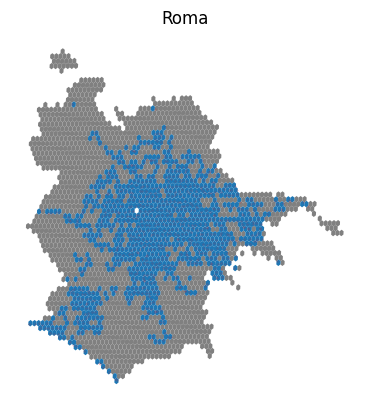

In [ ]:
# plot roma_hex with nearest stops

fig, ax = plt.subplots()

# color hexes black if there is no nearest stop
roma_hex[roma_hex.nearest_stop_id.isna()].plot(ax=ax, color='grey')
roma_hex[~roma_hex.nearest_stop_id.isna()].plot(ax=ax,)
ax.set_axis_off()

ax.set_title('Roma')

# plot the stops that are in the hexagons
stops_gdf[stops_gdf.stop_id.isin(roma_hex.nearest_stop_id)].plot(ax=ax, color='red', markersize=0.01)

fig.savefig('roma_hex_nearest_stops.png', dpi=300, bbox_inches='tight')

## Tempo di viaggio alle 8:00

In [ ]:
# get rid of orphan edges and nodes


missing_pos = check_missing_pos(G_merged)

G_merged = remove_missing_pos_nodes(G_merged)

orphan_edges = check_orphan_edges(G_merged)

G_merged = nx.DiGraph(G_merged)



Checking nodes: 100%|██████████| 3097/3097 [00:00<00:00, 3121787.91it/s]
Removing nodes: 0it [00:00, ?it/s]
Checking edges: 100%|██████████| 70894/70894 [00:00<00:00, 1038813.40it/s]


In [ ]:
start_time = convert_to_datetime('12:00:00')

for idx, row in tqdm(roma_hex.loc[roma_hex.nearest_stop_id.notna()].iterrows(), total=len(roma_hex), desc="Calculating accessibility"):
    roma_hex.loc[idx, 'accessibility'] = calculate_accessibility_for_hex(row, start_time)

Calculating accessibility:  38%|███▊      | 926/2453 [12:09<20:02,  1.27it/s]  


In [ ]:
# plot roma_hex with accessibility

fig, ax = plt.subplots()

# where accessibility is inf or None color grey
roma_hex[roma_hex.accessibility.isna() | (roma_hex.accessibility == float('inf'))].plot(ax=ax, color='grey')

# otherwise color by accessibility
roma_hex[~roma_hex.accessibility.isna() & (roma_hex.accessibility != float('inf'))].plot(ax=ax, column='accessibility', legend=True, cmap='viridis')

ax.set_axis_off()

ax.set_title('Roma')

# format choropleth bar in hours

from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=60)

cbar = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

cbar.set_array([])

cbar.set_clim(0, 60)



fig.savefig('roma_hex_accessibility.png', dpi=300, bbox_inches='tight')

plt.show()

NameError: name 'plt' is not defined